In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import uproot
import logging

import acts

from itertools import cycle

import awkward as ak

from gnn4itk_tools.detector_plotter import DetectorPlotter

[W interface.cpp:47] Warning: Loading nvfuser library failed with: Error in dlopen: libnvfuser_codegen.so: cannot open shared object file: No such file or directory (function LoadingNvfuserLibrary)


In [2]:
match_df = pd.read_csv("../tmp/no_threshold_2/performance_gnn_plus_ckf.csv", dtype={"particle_id": np.uint64})
match_df = match_df[ match_df.event == 0 ].copy()

In [3]:
particles = ak.to_dataframe(uproot.open("../tmp/simdata/particles_initial.root:particles").arrays(), how="inner").reset_index(drop=True)
particles = particles[ particles.event_id == 0 ].copy()
particles = particles[ particles.particle_id.isin(match_df.particle_id) ].copy()
particles.shape

(887, 22)

In [4]:
particles["matched"] = particles.particle_id.map(dict(zip(match_df.particle_id, match_df.matched)))
assert not any(pd.isna(particles.matched))
particles.head(2)

,event_id,particle_id,particle_type,process,vx,vy,vz,vt,px,py,...,eta,phi,pt,p,vertex_primary,vertex_secondary,particle,generation,sub_particle,matched
2,0,4503599677702144,-211,0,-0.006878,0.006443,26.299278,0.0,1.618853,-0.872867,...,-1.899954,-0.494505,1.839180,6.28555,1,0,3,0,0,1
3,0,4503599694479360,321,0,-0.006878,0.006443,26.299278,0.0,-0.340527,-1.401685,...,-3.243134,-1.809120,1.442456,18.50160,1,0,4,0,0,1


In [5]:
hits = uproot.open("../tmp/simdata/hits.root:hits").arrays(library="pd")
hits = hits[ (hits.event_id == 0) & (hits.tt < 25.0) ].copy()
hits["hit_id"] = np.arange(len(hits))
hits.head(2)

simhit_map = pd.read_csv("../tmp/no_threshold_2/digi/event000000000-measurement-simhit-map.csv")
measId_to_hitID = dict(zip(simhit_map.measurement_id, simhit_map.hit_id))
hitId_to_particleId = dict(zip(hits.hit_id, hits.particle_id))

def process_prototracks(tracks):
    tracks["hit_id"] = tracks["measurementId"].map(measId_to_hitID)
    tracks["tx"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.tx)))
    tracks["ty"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.ty)))
    tracks["tz"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.tz)))
    tracks["geometry_id"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.geometry_id)))
    tracks["particle_id"] = tracks.hit_id.map(hitId_to_particleId)
    return tracks

In [6]:
prototracks = pd.read_csv("../tmp/no_threshold_2/gnn_plus_ckf/event000000000-prototracks.csv")
prototracks = process_prototracks(prototracks)
gnn_prototracks = [ t for _, t in prototracks.groupby("trackId") ]
print("GNN prototracks:",len(gnn_prototracks))

GNN prototracks: 2819


In [7]:
true_prototracks = pd.read_csv("../tmp/no_threshold_2/proof_of_concept/event000000000-prototracks.csv")
true_prototracks = process_prototracks(true_prototracks)
true_prototracks = [ t for _, t in true_prototracks.groupby("trackId") ]
print("True prototracks:",len(true_prototracks))

True prototracks: 883


In [8]:
particles_eta_slice = particles[ particles.eta.between(-0.1,0.1) & (particles.matched == 0) ].reset_index()
len(particles_eta_slice)

1

In [9]:
prototracks_slice = [
    t for _, t in prototracks[ 
        prototracks.trackId.isin(
            np.unique(prototracks[ prototracks.particle_id.isin(particles_eta_slice.particle_id) ].trackId)
        )
    ].groupby("trackId") 
]
len(prototracks_slice)

0

In [10]:
graph = pd.read_csv("../tmp/no_threshold_2/gnn_plus_ckf/event000000000-exatrkx-graph.csv")
spacepoints = pd.read_csv("../tmp/no_threshold_2/digi/event000000000-spacepoint.csv")

for edge, poscols in [("edge0", ["x0","y0","z0"]), ("edge1", ["x1","y1","z1"])]:
    for c in poscols:
        graph[c] = graph[edge].map(dict(zip(spacepoints.measurement_id, spacepoints[c[:1]])))

graph["r0"] = np.hypot(graph.x0, graph.y0)
graph["r1"] = np.hypot(graph.x1, graph.y1)

graph.head(3)

,edge0,edge1,weight,x0,y0,z0,x1,y1,z1,r0,r1
0,5,2340,0.999589,98.324997,5.225,-1515.59998,85.474998,5.275000,-1315.59998,98.463728,85.637614
1,13,2348,0.999716,63.224998,-3.725,-1515.59998,54.775002,-3.575001,-1315.59998,63.334636,54.891542
2,14,83,0.999962,63.825001,7.225,-1515.59998,63.886929,7.205680,-1516.80005,64.232635,64.292002


In [11]:
class PrototrackPlotter(DetectorPlotter):
    def __init__(self):
        super().__init__("../config/detectors.csv", r_max=200, abs_z_max=1500)
    
    def plot_prototrack(self, prototrack : pd.DataFrame, graph : pd.DataFrame = None, random_factor=0.0, 
                        color_by_particles=True, large=False, text=True, text_edgeweight=False):
        tab_colors = matplotlib.colors.TABLEAU_COLORS.copy()
        del tab_colors["tab:red"]
        del tab_colors["tab:green"]
        
        if color_by_particles == False:
            colors = [ c for i, c in zip(range(len(prototrack)), cycle(tab_colors)) ]
        else:
            unique_pids = np.unique(prototrack.particle_id)
            pid_colors = [ c for i, c in zip(range(len(unique_pids)), cycle(tab_colors)) ]
            color_dict = dict(zip(unique_pids, pid_colors))
            colors = [ color_dict[pid] for pid in prototrack.particle_id ]
        
        # prototrack    
        prototrack = prototrack.copy()
        prototrack["r"] = np.hypot(prototrack.x, prototrack.y)
        
        pids, counts = np.unique(prototrack.particle_id, return_counts=True)
        pur = max(counts)/len(prototrack)

        if large:
            fig, ax = self.get_fig_ax(figsize=(13,15), ax_config=(2,1))
        else:
            fig, ax = self.get_fig_ax(figsize=(13,3))
        
        fig.suptitle("Prototrack with ID {} and length {}, particles: {}, purity: {:.1%}".format(str(prototrack.trackId.to_list()[0]),
                                                                                                 len(prototrack), len(pids), pur))
        
        # move around a bit so we see overlaps
        f = random_factor
        def randomify(x):
            x = x.to_numpy()
            d = max(x) - min(x)
            r = np.random.uniform(-f*d,f*d,len(x))
            return x + r
        
        # graph 
        if graph is not None:
            thisgraph = graph[ graph.edge0.isin(prototrack.measurementId) | graph.edge1.isin(prototrack.measurementId) ].copy()
            
            
            for k in ["x","y","z","r"]:
                for en in ["0","1"]:
                    thisgraph[k+en] = randomify(thisgraph[k+en])
    
            for _, row in thisgraph.iterrows():
                good_edge = (
                    prototrack[ prototrack.measurementId == row.edge0 ].particle_id.iloc[0] == 
                    prototrack[ prototrack.measurementId == row.edge1 ].particle_id.iloc[0]
                )
                color="green" if good_edge else "red"
                ax[0].plot([row.z0, row.z1], [row.r0, row.r1], color=color, zorder=-10, marker="x", alpha=0.7)
                ax[1].plot([row.x0, row.x1], [row.y0, row.y1], color=color, zorder=-10, marker="x", alpha=0.7)
                
                if text_edgeweight:
                    ax[0].text(0.5*(row.z0+row.z1), 0.5*(row.r0+row.r1), f"{row.weight:.2f}", va="center", ha="center", clip_on=True)
                    ax[1].text(0.5*(row.x0+row.x1), 0.5*(row.y0+row.y1), f"{row.weight:.2f}", va="center", ha="center", clip_on=True)
    
        for k in ["x","y","z","r"]:
            prototrack[k] = randomify(prototrack[k])
        
        ax[0].scatter(prototrack.z, prototrack.r, color=colors, marker="x")
        ax[1].scatter(prototrack.x, prototrack.y, color=colors, marker="x")

        range_vals = { "x": (np.inf, 0), "y": (np.inf, 0), "z": (np.inf, 0), "r": (np.inf, 0) }
        
        for c, (_, sp) in zip(colors, prototrack.iterrows()):
            if text:
                ax[0].text(sp.z, sp.r+5, str(int(sp.measurementId)), c=c, clip_on=True)
                ax[1].text(sp.x, sp.y+5, str(int(sp.measurementId)), c=c, clip_on=True)
            
            for coor in ["x","y","z","r"]:
                range_vals[coor] = min(sp[coor], range_vals[coor][0]), max(sp[coor], range_vals[coor][1])

        def enlarge_range(r):
            d = r[1] - r[0]
            return r[0] - 0.05*d, r[1] + 0.05*d
        
        ax[0].set_xlim(*enlarge_range(range_vals["z"]))
        ax[0].set_ylim(*enlarge_range(range_vals["r"]))
        ax[1].set_xlim(*enlarge_range(range_vals["x"]))
        ax[1].set_ylim(*enlarge_range(range_vals["y"]))
        
        ax[0].set_xlabel("z")
        ax[0].set_ylabel("r")
        ax[1].set_xlabel("x")
        ax[1].set_ylabel("y")
    
        fig.tight_layout()
        return fig, ax

In [12]:
plotter = PrototrackPlotter()

## Track #0

In [13]:
#prototracks_slice[0]

In [14]:
#particles[ particles.particle_id.isin(prototracks_slice[0].particle_id) ]

In [15]:
#fig, ax = plotter.plot_prototrack(prototracks_slice[0], graph, 0)

#ax[0].set_xlim(-100, 100)
#ax[1].set_ylim(0, 30)
#ax[1].set_xlim(0, 200)

## Track #1

In [16]:
#prototracks_slice[1]

In [17]:
#particles_eta_slice[ particles_eta_slice.particle_id.isin(prototracks_slice[1].particle_id) ]

In [18]:
#fig, ax = plotter.plot_prototrack(prototracks_slice[1], graph)
#ax[0].set_xlim(-100, 100)
#ax[0].set_ylim(0, 200)
#ax[1].set_ylim(-50, 10)
#ax[1].set_xlim(0, 200)

## Look at largest prototracks

In [19]:
particles_not_matched = particles[ particles.matched == 0 ].reset_index()
len(particles_not_matched)

61

In [20]:
prototracks_all_not_matched = [
    t for _, t in prototracks[ 
        prototracks.trackId.isin(
            np.unique(prototracks[ prototracks.particle_id.isin(particles_not_matched.particle_id) ].trackId)
        )
    ].groupby("trackId") 
]

In [21]:
prototracks_all_not_matched = sorted(prototracks_all_not_matched, key=lambda t: len(t))

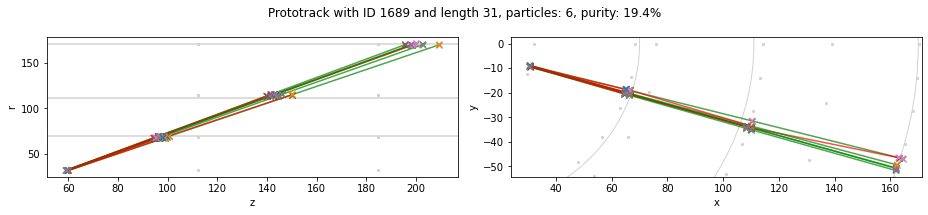

In [22]:
fig, ax = plotter.plot_prototrack(prototracks_all_not_matched[-1], graph, text=False)

(25.0, 100.0)

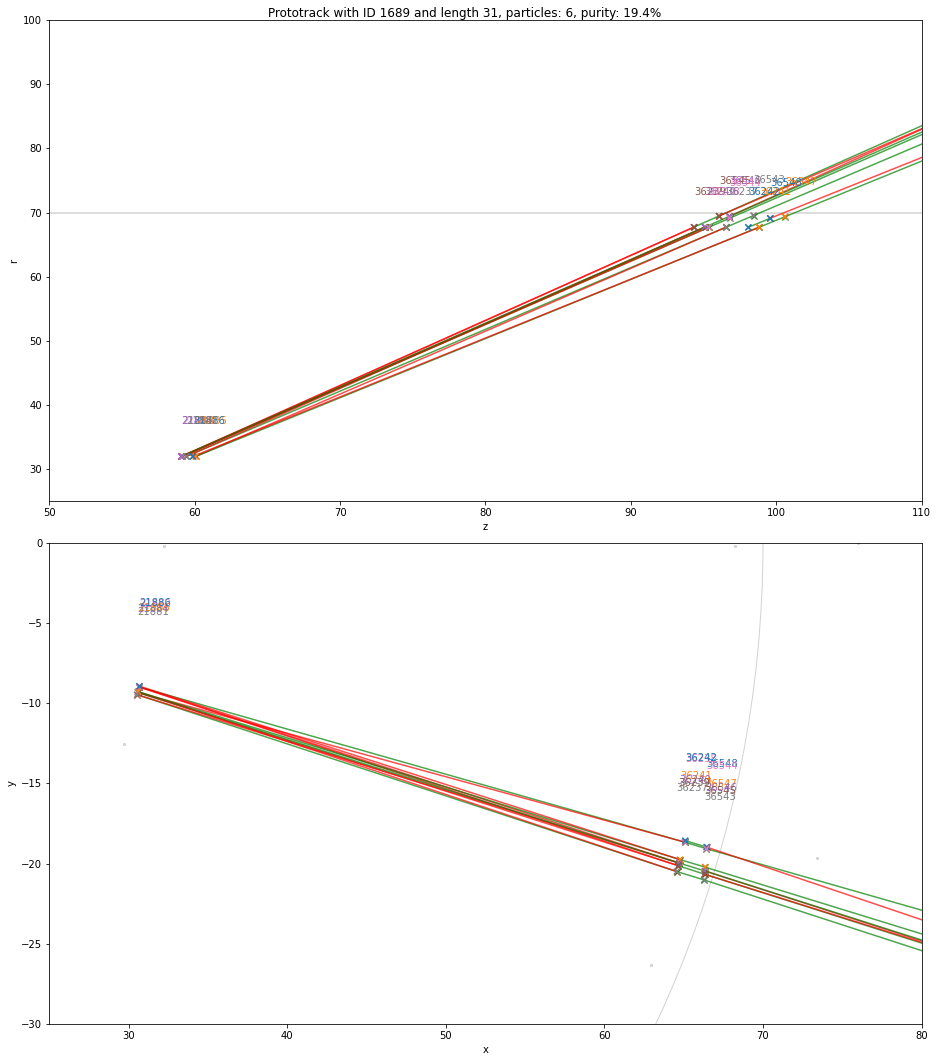

In [23]:
fig, ax = plotter.plot_prototrack(prototracks_all_not_matched[-1], graph, large=True, random_factor=0.0)

ax[1].set_xlim(25,80)
ax[1].set_ylim(-30,0)
ax[0].set_xlim(50,110)
ax[0].set_ylim(25,100)